In [48]:
%load_ext autoreload
%autoreload 2
import numpy as np
import matplotlib.pyplot as plt
from ldic_utils import (process_all_scans, load_json_to_dict_list, 
                        save_dict_list_to_json,load_image_mask,bbox_crop,
                        plot_mask_contours,load_slices)
import pylidc as pl
import jlc

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [67]:
scans = pl.query(pl.Scan).all() 
process_all_scans(scans,raw_images=True,crop_bbox_per_slice=True)

  2%|▏         | 21/1018 [00:02<01:55,  8.65it/s]


no masks found for nodule 0 in slice 4 with bbox (slice(324, 338, None), slice(105, 117, None), slice(27, 32, None)) and number of masks 4


AssertionError: mask is empty

In [29]:
data = load_json_to_dict_list("data.jsonl")
scan_id = 1
nodule_id = 0
slice_id = 0
image_dict = data[scan_id]["nodules"][nodule_id][slice_id]
bbox = image_dict["bbox"]
image_id = image_dict["image_id"]
mask_id = image_dict["masks_id"]

{'bbox': [372, 399, 350, 372], 'slice': 67, 'image_id': 43, 'masks_id': [163, 164, 165, 166]}


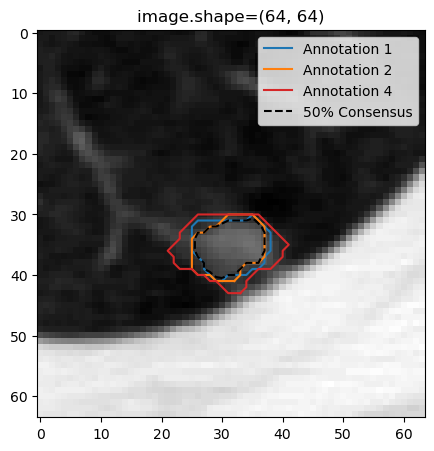

In [46]:
data = load_json_to_dict_list("data.jsonl")
idx_pairs = [] # (scan_id, image_id, mask_id)
for scan_id,scan in enumerate(data):
    for nod in scan["nodules"]:
        for image in nod:
            idx_pairs.extend([(scan_id,image["image_id"],mask_id) for mask_id in image["masks_id"]])

if True:
    data = load_json_to_dict_list("data.jsonl")
    scan_id = 2
    nodule_id = 0
    slice_id = 0
    image_dict = data[scan_id]["nodules"][nodule_id][slice_id]
    print(image_dict)
    bbox = image_dict["bbox"]
    image_id = image_dict["image_id"]
    mask_id = image_dict["masks_id"]
if False:
    scan_id,image_id,mask_id = idx_pairs[14]
    #mask_id = mask_id
image,mask,bbox = load_image_mask(scan_id, image_id, mask_id, data)
image,mask = bbox_crop(image,mask,bbox=bbox,size=64)
plt.figure(figsize=(5,10))
plt.title(f"image.shape={image.shape}")
plt.imshow(image,cmap="gray")
plot_mask_contours([mask[:,:,i] for i in range(mask.shape[2])])
plt.legend()

In [44]:

# Query for a scan, and convert it to an array volume.
#scan = pl.query(pl.Scan).filter(pl.Scan.patient_id == 'LIDC-IDRI-0078').first()
scan_id,nodule_id,slice_idx = 2,0,0
scan =  pl.query(pl.Scan)[scan_id]
vol = scan.to_volume()

# Cluster the annotations for the scan, and grab one.
nods = scan.cluster_annotations()
anns = nods[nodule_id]

# Perform a consensus consolidation and 50% agreement level.
# We pad the slices to add context for viewing.
p = 32
cmask,cbbox,masks = pl.utils.consensus(anns, clevel=0.5,
                              pad=[(p,p), (p,p), (0,0)])
_,cbbox2,_ = pl.utils.consensus(anns, clevel=0.5)

#slices = load_slices(scan,cbbox2[2])
# Get the central slice of the computed bounding box.
#k = int(0.5*(cbbox[2].stop - cbbox[2].start)
k = slice_idx
assert k < cbbox[2].stop - cbbox[2].start

Loading dicom files ... This may take a moment.


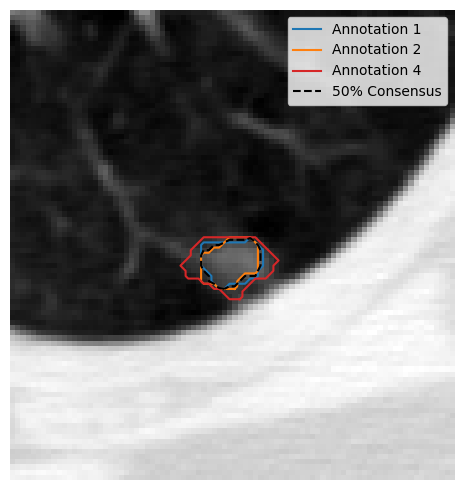

In [45]:
# Set up the plot.

fig,ax = plt.subplots(1,1,figsize=(5,5))
im = jlc.quantile_normalize(vol[cbbox][:,:,k],alpha=0.001)
#im = jlc.quantile_normalize(slices[k],alpha=0.001)
ax.imshow(im, cmap=plt.cm.gray)

# Plot the annotation contours for the kth slice.
plot_mask_contours([m[:,:,k].astype(float) for m in masks])
"""colors = ['r', 'g', 'b', 'y']
for j in range(len(masks)):
    for c in find_contours(masks[j][:,:,k].astype(float), 0.5):
        label = "Annotation %d" % (j+1)
        plt.plot(c[:,1], c[:,0], colors[j], label=label)

# Plot the 50% consensus contour for the kth slice.
for c in find_contours(cmask[:,:,k].astype(float), 0.5):
    plt.plot(c[:,1], c[:,0], '--k', label='50% Consensus')"""
if False:
    #show the bbox of our slice
    bbox_x = [cbbox2[1].start, cbbox2[1].start, cbbox2[1].stop, cbbox2[1].stop,  cbbox2[1].start]
    bbox_y = [cbbox2[0].start, cbbox2[0].stop,  cbbox2[0].stop, cbbox2[0].start, cbbox2[0].start]
    ax.plot(bbox_x, bbox_y, 'r')

ax.axis('off')
ax.legend()
plt.tight_layout()
#plt.savefig("../images/consensus.png", bbox_inches="tight")
plt.show()



In [34]:

#list the attributes of scan object
print([attr for attr in dir(scan) if not attr.startswith('_')])

Help on method to_volume in module pylidc.Scan:

to_volume(verbose=True) method of pylidc.Scan.Scan instance
    Return the scan as a 3D numpy array volume.

['annotations', 'cluster_annotations', 'contrast_used', 'get_path_to_dicom_files', 'id', 'is_from_initial', 'load_all_dicom_images', 'metadata', 'patient_id', 'pixel_spacing', 'registry', 'series_instance_uid', 'slice_spacing', 'slice_thickness', 'slice_zvals', 'sorted_dicom_file_names', 'spacings', 'study_instance_uid', 'to_volume', 'visualize', 'zvals']
